# Single Catenary Line using ztarg

In [1]:
import numpy as np
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

## Define properties of the line

Keeping all variables in SI Units (kg, m, s) and force in N

In [2]:
g = 9.81 #m/s2
W_pm = 376 #kg/m
EA = 1861000000 #N
L_tot = 600 #m

## End-point of Catenary

The following function calculates XZ position of the end point of the catenary line based on

- W_pm = Mass per meter (kg/m)
- EA (N)
- H0 = Horizontal force at the anchor = Horizontal force at end point
- L = Suspended length of the line
- V0 = Vertical force at the anchor point

In [3]:
def catenary_end_xz(W_pm, EA, H0, L, V0):
    
    W = W_pm*L*g
        
    
    s = L
    x = H0*s/EA + H0*L/W*(np.arcsinh(V0/H0) - np.arcsinh((V0 - W*s/L)/H0))
    z_t1 = 1 + (V0/H0)**2
    z_t2 = 1 + ((V0 - W*s/L)/H0)**2
    z = W*s/EA * (s/2/L - V0/W) - H0*L/W*(np.sqrt(z_t1) - np.sqrt(z_t2))            
        
    return x, z

Testing the above function for a hypothetical line.

In [4]:
print(catenary_end_xz(W_pm, EA, 106000, 400, 0))

(95.6524725985454, 372.4520369743113)


## Plotting the entire catenary line

The following function returns the entire shape of the catenary line based on 

- W_pm = Mass per meter (kg/m)
- EA (N)
- H0 = Horizontal force at the anchor = Horizontal force at end point
- L = Suspended length of the line
- V0 = Vertical force at the anchor point
- ds = Resolution for the plot

In [5]:
def catenary_xz(W_pm, EA, H0, L, V0, ds):
    
    W = W_pm*L*g
    
    c_s = [0]
    c_stot = [0]
    c_x = [0]
    c_z = [0]
    c_H = [H0]
    c_V = [V0]
    
    Ns = math.floor(L/ds)
    for i in range(1,Ns+1):
        s = c_s[-1]+ds
        x = H0*s/EA + H0*L/W*(np.arcsinh(V0/H0) - np.arcsinh((V0 - W*s/L)/H0))
        z_t1 = 1 + (V0/H0)**2
        z_t2 = 1 + ((V0 - W*s/L)/H0)**2
        z = W*s/EA * (V0/W - s/2/L) + H0*L/W*(np.sqrt(z_t1) - np.sqrt(z_t2))
        z = -z
        dstot = np.sqrt((x-c_x[-1])**2 + (z - c_z[-1])**2)
        V = V0 + W_pm*s*g
        
        c_s.append(s)
        c_stot.append( c_stot[-1]+dstot )
        c_x.append( x )
        c_z.append( z )
        c_H.append( H0 )
        c_V.append( V )
        
    print(c_s[-1], c_x[-1], c_z[-1], c_V[-1], c_stot[-1])
        
    return c_s, c_x, c_z, c_V, c_stot

Testing the above function for a hypothetical line.

400.00000000002245 95.652472598547 372.45203697433374 1475424.000000083 400.16168325996887


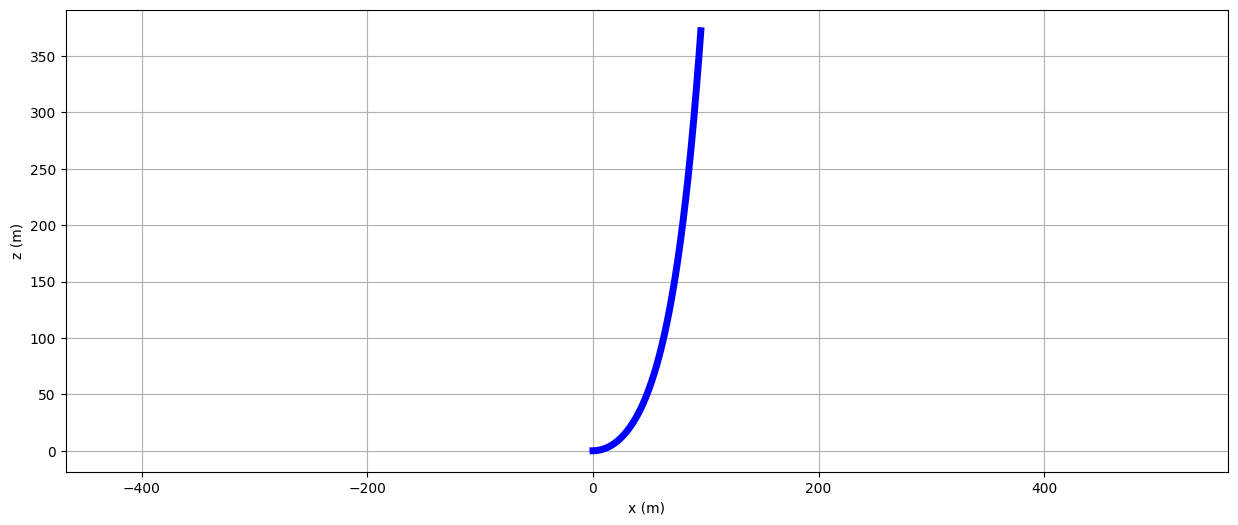

In [6]:
l2_s, l2_x, l2_z, l2_V, l2_stot = catenary_xz(W_pm, EA, 106000, 400, 0, 0.1)

plt.plot(l2_x, l2_z, 'b-', lw=5)
plt.axis("equal")
plt.grid("on")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
pass

## Solution for H0

- The above-mentioned functions require input of H0.
- The value of H0 is numerically calculated based on the desired vertical position z_target of the end-point of the catenary line.
- The following objective function calculates the difference between z_target and the z position obtained for a give H0.
- This objective function will be optimized using scipy.optimize.fsolve to numerically estimate the H0 solution for a given z_target.

In [7]:
def objective_fnc(H0, *data):        
    W_pm, EA, L, V0, ztarg  = data
    W = W_pm*L*g
    z_t1 = 1 + (V0/H0)**2
    z_t2 = 1 + ((V0 - W)/H0)**2
    z = W*L/EA * (1/2-V0/W) - H0*L/W*(np.sqrt(z_t1) - np.sqrt(z_t2))
    return (ztarg-z)

data = (W_pm, EA, 400, 0, 200)
root = optimize.fsolve(objective_fnc,10,args=data)
print(root[0])
print(objective_fnc(root[0], *data))

1108031.0962915097
5.684341886080802e-14


## Force-excursion diagram

- Consider a catenary line which has a total length (L_tot) = 600 m.
- We now evaluate the horizontal force (H0) for a range of suspended length (L_susp) for the caternary line.
- We also evaluate the corresponding x position of the suspended portion of the catenary line.
- The total horizontal excursion of the line will be = (length of line on bed) + (horizontal projection of the suspended portion)
- The plot of H0 vs x is the force-excursion plot.
- Here the z_target can be fixed as the still-water depth (d0)

6.209535943854874 200.0 3.8462192338745558
554.5522458359378 200.00000000000006 2946.3402036821817


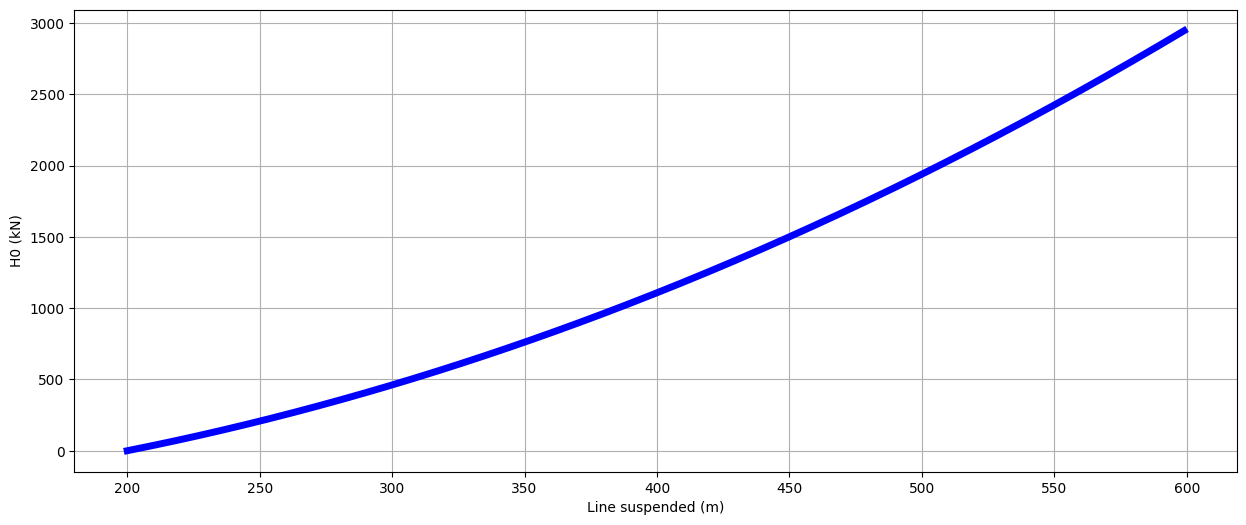

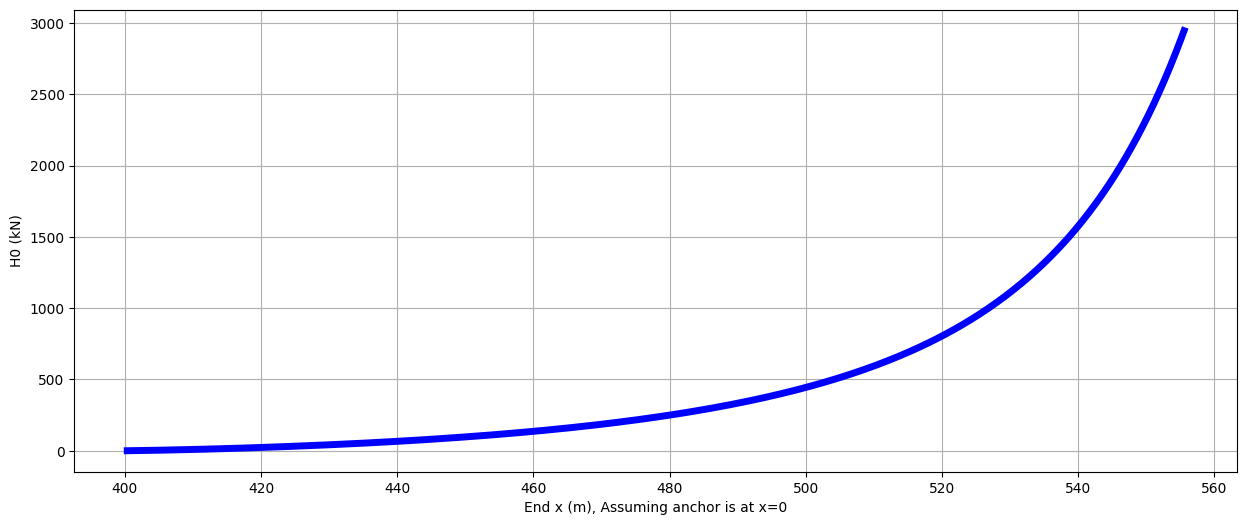

In [8]:
# Still-water depth
d0 = 200 #m

L_tot = 600
L_susp = np.arange(d0,L_tot)

H0_array = [optimize.fsolve(objective_fnc,10,args=(W_pm, EA, l0, 0, d0)) for l0 in L_susp]
H0_array = [sol[0] for sol in H0_array]

xz_end_array = [catenary_end_xz(W_pm, EA, lH0, l0, 0) for lH0,l0 in zip(H0_array,L_susp)]
x_end_array = [x for x,z in xz_end_array]
z_end_array = [z for x,z in xz_end_array]
print(x_end_array[1], z_end_array[1], H0_array[1]/1000)
print(x_end_array[-1], z_end_array[-1], H0_array[-1]/1000)

plt.subplots(1,1)
plt.plot(L_susp, [Hl/1000 for Hl in H0_array], 'b-', lw=5)
plt.grid("on")
plt.xlabel('Line suspended (m)')
plt.ylabel('H0 (kN)')

plt.subplots(1,1)
plt.plot( L_tot - L_susp + x_end_array, [Hl/1000 for Hl in H0_array], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('H0 (kN)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)
pass